# Trajectories by simple integration for advected waves and unadvected waves

In [1]:
import numpy as np
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt

import xsimlab as xs

## Classes

In [2]:
@xs.process
class ProfileP:
    """Compute the evolution of positions and velocities."""

    p_vars = xs.group("p_vars")
    p = xs.variable(dims="p", intent="inout", description="positions of particules", attrs={"units": "m"})#attrs to print the units on graphs
    
    v_vars = xs.group("v_vars")
    v = xs.variable(dims="v", intent="inout", description="velocity of particules", attrs={"units": "m/s"})

    def run_step(self):
        self._delta_p = sum((x for x in self.p_vars))
        self._delta_v = sum((u for u in self.v_vars))

    def finalize_step(self):
        self.v += self._delta_v
        self.p += self._delta_p


In [47]:
def analytical_velocity_advected(t, x, um, uw, w, k):
    return um + uw*np.cos(w*t-k*(x-um*t))

@xs.process
class AdvectedWave:
    """Calculate velocity at t and in all positions.
"""
    um = xs.variable(description="uniform and constant flow amplitude", attrs={"units":"m/s"})
    uw = xs.variable(description="wave amplitude", attrs={"units":"m/s"})
    w = xs.variable(description="wave pulsation", attrs={"units":"s^-1"})
    k = xs.variable(description="wave number", attrs={"units":"m⁻1"})

    v = xs.foreign(ProfileP, "v", intent="out")
    p = xs.foreign(ProfileP, "p")

    v_diff = xs.variable(dims="v", intent="out", groups="v_vars")
    
    #INITIALISATION OF VELOCITY
    @xs.runtime(args="sim_start")#this way t is the beginning time of the simulation
    def initialize(self,t):
        self.v = self.um + self.uw*np.cos(self.w*t-self.k*(self.p-self.um*t))
    
    #CALCULATION OF VELOCITY AT t time and position p
    @xs.runtime(args="step_start")#then t=current step start (date)time
    def run_step(self,t):
        self.v_diff = analytical_velocity_advected(t, self.p, self.um, self.uw, self.w, self.k)-self.v
        #self.v_diff = self.um + self.uw*np.cos(self.w*t-self.k*(self.p-self.um*t))-self.v
        #first step calculate 0, it is not very useful, is that a problem?


In [140]:
def analytical_velocity_unadvected(t, x, um, uw, w, k):
    return um + uw*np.cos(w*t-k*x)


@xs.process
class UnadvectedWave:
    """Calculate velocity at t and in all positions.
"""
    um = xs.variable(description="uniform and constant flow amplitude", attrs={"units":"m/s"})
    uw = xs.variable(description="wave amplitude", attrs={"units":"m/s"})
    w = xs.variable(description="wave pulsation", attrs={"units":"s^-1"})
    k = xs.variable(description="wave number", attrs={"units":"m⁻1"})

    v = xs.foreign(ProfileP, "v", intent="out")
    p = xs.foreign(ProfileP, "p")

    v_diff = xs.variable(dims="v", intent="out", groups="v_vars")
    
    @xs.runtime(args="sim_start")
    def initialize(self,t):
        self.v = self.um + self.uw*np.cos(self.w*t-self.k*self.p)
        
    @xs.runtime(args="step_start")#then t=current step start (date)time
    def run_step(self,t):
        #self.v_diff = self.um + self.uw*np.cos(self.w*t-self.k*self.p)-self.v
        self.v_diff = analytical_velocity_unadvected(t, self.p, self.um, self.uw, self.w, self.k) - self.v
        #first step calculate 0, it is not very useful, is that a problem?


In [141]:
@xs.process
class Euler:
    """Calculate positions at t+dt using Euler method.
"""
    p_advected = xs.variable(dims="p", intent="out", groups="p_vars")
    v = xs.foreign(ProfileP,"v")

    @xs.runtime(args="step_delta")
    def run_step(self, dt):
        self.p_advected = self.v*dt

In [142]:
@xs.process
class InitRegular:
    """Initialize `positions` profile with N regular values in a giving an interval."""

    mini = xs.variable(description="minimum for initial position", static=True)
    maxi = xs.variable(description="maximum for initial position", static=True)
    N =xs.variable(description="number of particules", static=True)
    p = xs.foreign(ProfileP, "p", intent="out")
    
      
    def initialize(self):
        self.p = np.linspace(self.mini, self.maxi, self.N)


## Model for advected waves integrated with the Euler method

In [143]:
# CREATE xs.Model
advect_model = xs.Model(
    {
        "profile": ProfileP,
        "init": InitRegular,
        "intmethod": Euler,
        "velocity": AdvectedWave
    }
)


In [144]:
advect_model

<xsimlab.Model (4 processes, 7 inputs)>
init
    mini        [in] minimum for initial position
    maxi        [in] maximum for initial position
    N           [in] number of particules
velocity
    um          [in] uniform and constant flow amplitude
    uw          [in] wave amplitude
    w           [in] wave pulsation
    k           [in] wave number
intmethod
profile

In [145]:
#CREATE SET UP
in_ds_advect = xs.create_setup(model=advect_model, 
                        clocks={'time': np.linspace(0,48*3600, 201),
                                'otime': [0, 864,1728,64800,86400, 108000,172800 ]}, 
                        master_clock='time',
                        input_vars={'init': {'mini': 0., 'maxi': 200000., 'N':100},#INITIALISATION
                                    'velocity': {'um': 0.1, 'uw': 0.1, 'w':1.4*10**(-4), 'k':6.10**(-5)},
                                    },
                        output_vars={'profile__p' : 'otime',})


In [146]:
in_ds_advect

<xarray.Dataset>
Dimensions:       (otime: 7, time: 201)
Coordinates:
  * time          (time) float64 0.0 864.0 1.728e+03 ... 1.719e+05 1.728e+05
  * otime         (otime) int64 0 864 1728 64800 86400 108000 172800
Data variables:
    init__mini    float64 0.0
    init__maxi    float64 2e+05
    init__N       int64 100
    velocity__um  float64 0.1
    velocity__uw  float64 0.1
    velocity__w   float64 0.00014
    velocity__k   float64 0.0001184

In [147]:
out_ds_advect = in_ds_advect.xsimlab.run(model=advect_model)
out_ds_advect

<xarray.Dataset>
Dimensions:       (otime: 7, p: 100, time: 201)
Coordinates:
  * otime         (otime) int64 0 864 1728 64800 86400 108000 172800
  * time          (time) float64 0.0 864.0 1.728e+03 ... 1.719e+05 1.728e+05
Dimensions without coordinates: p
Data variables:
    init__N       int64 100
    init__maxi    float64 2e+05
    init__mini    float64 0.0
    profile__p    (otime, p) float64 0.0 2.02e+03 ... 2.156e+05 2.175e+05
    velocity__k   float64 0.0001184
    velocity__um  float64 0.1
    velocity__uw  float64 0.1
    velocity__w   float64 0.00014

### Positions plots

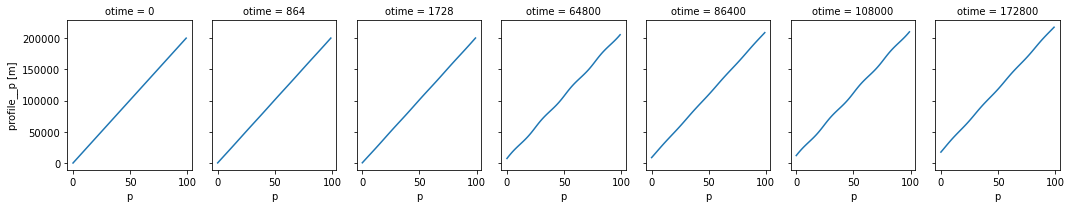

In [148]:
p = out_ds_advect.profile__p
p.plot(col="otime", figsize=(15,3));

In [149]:
p = p.assign_coords(p=p.isel(otime=0, drop=True))
p

<xarray.DataArray 'profile__p' (otime: 7, p: 100)>
array([[0.00000000e+00, 2.02020202e+03, 4.04040404e+03, 6.06060606e+03,
        8.08080808e+03, 1.01010101e+04, 1.21212121e+04, 1.41414141e+04,
        1.61616162e+04, 1.81818182e+04, 2.02020202e+04, 2.22222222e+04,
        2.42424242e+04, 2.62626263e+04, 2.82828283e+04, 3.03030303e+04,
        3.23232323e+04, 3.43434343e+04, 3.63636364e+04, 3.83838384e+04,
        4.04040404e+04, 4.24242424e+04, 4.44444444e+04, 4.64646465e+04,
        4.84848485e+04, 5.05050505e+04, 5.25252525e+04, 5.45454545e+04,
        5.65656566e+04, 5.85858586e+04, 6.06060606e+04, 6.26262626e+04,
        6.46464646e+04, 6.66666667e+04, 6.86868687e+04, 7.07070707e+04,
        7.27272727e+04, 7.47474747e+04, 7.67676768e+04, 7.87878788e+04,
        8.08080808e+04, 8.28282828e+04, 8.48484848e+04, 8.68686869e+04,
        8.88888889e+04, 9.09090909e+04, 9.29292929e+04, 9.49494949e+04,
        9.69696970e+04, 9.89898990e+04, 1.01010101e+05, 1.03030303e+05,
        1.05050505e+05, 1.07070707e+05, 1.09090909e+05, 1.11111111e+05,
        1.13131313e+05, 1.15151515e+05, 1.17171717e+05, 1.19191919e+05,
        1.21212121e+05, 1.23232323e+05, 1.25252525e+05, 1.27272727e+05,
        1.29292929e+05, 1.31313131e+05, 1.33333333e+05, 1.35353535e+05,
        1.37373737e+05, 1.39393939e+05, 1.41414141e+05, 1.43434343e+05,
        1.45454545e+05, 1.47474747e+05, 1.49494949e+05, 1.51515152e+05,
        1.53535354e+05, 1.55555556e+05, 1.57575758e+05, 1.59595960e+05,
...
        5.79517807e+04, 5.98649462e+04, 6.18085504e+04, 6.37877487e+04,
        6.58061923e+04, 6.78655692e+04, 6.99651577e+04, 7.21014869e+04,
        7.42682266e+04, 7.64564188e+04, 7.86551068e+04, 8.08523138e+04,
        8.30362126e+04, 8.51962633e+04, 8.73241081e+04, 8.94140984e+04,
        9.14634375e+04, 9.34720113e+04, 9.54420223e+04, 9.73775370e+04,
        9.92840340e+04, 1.01168000e+05, 1.03036594e+05, 1.04897380e+05,
        1.06758108e+05, 1.08626519e+05, 1.10510164e+05, 1.12416185e+05,
        1.14351060e+05, 1.16320275e+05, 1.18327928e+05, 1.20376280e+05,
        1.22465297e+05, 1.24592267e+05, 1.26751622e+05, 1.28935064e+05,
        1.31132088e+05, 1.33330882e+05, 1.35519460e+05, 1.37686836e+05,
        1.39823999e+05, 1.41924543e+05, 1.43984912e+05, 1.46004300e+05,
        1.47984333e+05, 1.49928621e+05, 1.51842305e+05, 1.53731639e+05,
        1.55603629e+05, 1.57465755e+05, 1.59325734e+05, 1.61191330e+05,
        1.63070163e+05, 1.64969509e+05, 1.66896052e+05, 1.68855581e+05,
        1.70852609e+05, 1.72889936e+05, 1.74968187e+05, 1.77085397e+05,
        1.79236766e+05, 1.81414695e+05, 1.83609198e+05, 1.85808708e+05,
        1.88001168e+05, 1.90175217e+05, 1.92321235e+05, 1.94432077e+05,
        1.96503419e+05, 1.98533743e+05, 2.00524059e+05, 2.02477493e+05,
        2.04398818e+05, 2.06294026e+05, 2.08169953e+05, 2.10033975e+05,
        2.11893766e+05, 2.13757097e+05, 2.15631644e+05, 2.17524798e+05]])
Coordinates:
  * otime    (otime) int64 0 864 1728 64800 86400 108000 172800
  * p        (p) float64 0.0 2.02e+03 4.04e+03 ... 1.96e+05 1.98e+05 2e+05
Attributes:
    description:  positions of particules
    units:        m

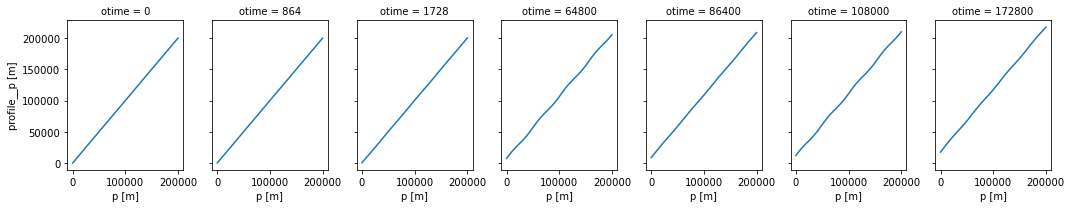

In [150]:
p.plot(col="otime", figsize=(15,3));

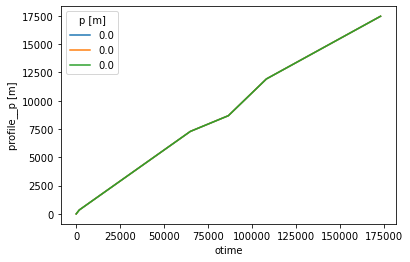

In [151]:
_ = p.sel(p=[0, 1., 2.], method='nearest').plot.line(x='otime')

In [152]:
out_vars = {'profile__v':'otime'}
with advect_model:
    out_ds_advect2 = (in_ds_advect.xsimlab.update_vars(output_vars=out_vars).xsimlab.run())
out_ds_advect2

<xarray.Dataset>
Dimensions:       (otime: 7, p: 100, time: 201, v: 100)
Coordinates:
  * otime         (otime) int64 0 864 1728 64800 86400 108000 172800
  * time          (time) float64 0.0 864.0 1.728e+03 ... 1.719e+05 1.728e+05
Dimensions without coordinates: p, v
Data variables:
    init__N       int64 100
    init__maxi    float64 2e+05
    init__mini    float64 0.0
    profile__p    (otime, p) float64 0.0 2.02e+03 ... 2.156e+05 2.175e+05
    profile__v    (otime, v) float64 0.2 0.1972 0.1888 ... 0.1685 0.1828 0.1932
    velocity__k   float64 0.0001184
    velocity__um  float64 0.1
    velocity__uw  float64 0.1
    velocity__w   float64 0.00014

In [153]:
v = out_ds_advect2.profile__v
v

<xarray.DataArray 'profile__v' (otime: 7, v: 100)>
array([[2.00000000e-01, 1.97152986e-01, 1.88774052e-01, 1.75340298e-01,
        1.57616646e-01, 1.36612285e-01, 1.13523210e-01, 8.96641197e-02,
        6.63935573e-02, 4.50365555e-02, 2.68091882e-02, 1.27493269e-02,
        3.65754421e-03, 5.15288713e-05, 2.13660844e-03, 9.79405789e-03,
        2.25878598e-02, 3.97895314e-02, 6.04196046e-02, 8.33033969e-02,
        1.07137899e-01, 1.30565966e-01, 1.52253599e-01, 1.70965897e-01,
        1.85637376e-01, 1.95432638e-01, 1.99793938e-01, 1.98472942e-01,
        1.91544868e-01, 1.79404203e-01, 1.62742240e-01, 1.42507715e-01,
        1.19852789e-01, 9.60674391e-02, 7.25060105e-02, 5.05100976e-02,
        3.13321540e-02, 1.60641775e-02, 5.57553109e-03, 4.63441270e-04,
        1.01899195e-03, 7.21054991e-03, 1.86855660e-02, 3.47906496e-02,
        5.46087725e-02, 7.70114850e-02, 1.00723170e-01, 1.24393678e-01,
        1.46675203e-01, 1.66299028e-01, 1.82147767e-01, 1.93318988e-01,
        1.99176600e-01, 1.99387067e-01, 1.93938405e-01, 1.83140864e-01,
        1.67609258e-01, 1.48227961e-01, 1.26100550e-01, 1.02486966e-01,
        7.87317732e-02, 5.61875997e-02, 3.61381170e-02, 1.97249485e-02,
        7.88266459e-03, 1.28556847e-03, 3.09300698e-04, 5.00945023e-03,
        1.51183892e-02, 3.00605117e-02, 4.89850089e-02, 7.08143145e-02,
        9.43054614e-02, 1.18120857e-01, 1.40904446e-01, 1.61358924e-01,
        1.78319607e-01, 1.90820748e-01, 1.98150530e-01, 1.99891593e-01,
...
        1.91482853e-01, 1.98207319e-01, 1.99917702e-01, 1.96227540e-01,
        1.86993070e-01, 1.72394596e-01, 1.53011568e-01, 1.29866229e-01,
        1.04406701e-01, 7.84077979e-02, 5.37899121e-02, 3.23868814e-02,
        1.57178018e-02, 4.81998950e-03, 1.77956853e-04, 1.74897523e-03,
        9.05778039e-03, 2.13220182e-02, 3.75750763e-02, 5.67659855e-02,
        7.78292193e-02, 9.97263498e-02, 1.21466080e-01, 1.42110454e-01,
        1.60774618e-01, 1.76626610e-01, 1.88892791e-01, 1.96873962e-01,
        1.99976526e-01, 1.97761690e-01, 1.90012751e-01, 1.76815001e-01,
        1.58634631e-01, 1.36373665e-01, 1.11372000e-01, 8.53314359e-02,
        6.01548129e-02, 3.77228828e-02, 1.96590555e-02, 7.14123118e-03,
        8.03495941e-04, 7.37553195e-04, 6.57251991e-03, 1.75958241e-02,
        3.28793293e-02, 5.13865865e-02, 7.20508133e-02, 9.38235814e-02,
        1.15699899e-01, 1.36727369e-01, 1.56007013e-01, 1.72692468e-01,
        1.85993382e-01, 1.95188211e-01, 1.99650957e-01, 1.98895377e-01,
        1.92637658e-01, 1.80873897e-01, 1.63961153e-01, 1.42681527e-01,
        1.18261268e-01, 9.23174414e-02, 6.67189632e-02, 4.33761965e-02,
        2.40030541e-02, 9.91088358e-03, 1.88357977e-03, 1.53249469e-04,
        4.46231020e-03, 1.41771957e-02, 2.84160288e-02, 4.61624962e-02,
        6.63520337e-02, 8.79279757e-02, 1.09872251e-01, 1.31218047e-01,
        1.51052169e-01, 1.68514066e-01, 1.82797575e-01, 1.93160706e-01]])
Coordinates:
  * otime    (otime) int64 0 864 1728 64800 86400 108000 172800
Dimensions without coordinates: v
Attributes:
    description:  velocity of particules
    units:        m/s

In [154]:
out_ds_advect2.profile__v.sel(otime=0, method='nearest')

<xarray.DataArray 'profile__v' (v: 100)>
array([2.00000000e-01, 1.97152986e-01, 1.88774052e-01, 1.75340298e-01,
       1.57616646e-01, 1.36612285e-01, 1.13523210e-01, 8.96641197e-02,
       6.63935573e-02, 4.50365555e-02, 2.68091882e-02, 1.27493269e-02,
       3.65754421e-03, 5.15288713e-05, 2.13660844e-03, 9.79405789e-03,
       2.25878598e-02, 3.97895314e-02, 6.04196046e-02, 8.33033969e-02,
       1.07137899e-01, 1.30565966e-01, 1.52253599e-01, 1.70965897e-01,
       1.85637376e-01, 1.95432638e-01, 1.99793938e-01, 1.98472942e-01,
       1.91544868e-01, 1.79404203e-01, 1.62742240e-01, 1.42507715e-01,
       1.19852789e-01, 9.60674391e-02, 7.25060105e-02, 5.05100976e-02,
       3.13321540e-02, 1.60641775e-02, 5.57553109e-03, 4.63441270e-04,
       1.01899195e-03, 7.21054991e-03, 1.86855660e-02, 3.47906496e-02,
       5.46087725e-02, 7.70114850e-02, 1.00723170e-01, 1.24393678e-01,
       1.46675203e-01, 1.66299028e-01, 1.82147767e-01, 1.93318988e-01,
       1.99176600e-01, 1.99387067e-01, 1.93938405e-01, 1.83140864e-01,
       1.67609258e-01, 1.48227961e-01, 1.26100550e-01, 1.02486966e-01,
       7.87317732e-02, 5.61875997e-02, 3.61381170e-02, 1.97249485e-02,
       7.88266459e-03, 1.28556847e-03, 3.09300698e-04, 5.00945023e-03,
       1.51183892e-02, 3.00605117e-02, 4.89850089e-02, 7.08143145e-02,
       9.43054614e-02, 1.18120857e-01, 1.40904446e-01, 1.61358924e-01,
       1.78319607e-01, 1.90820748e-01, 1.98150530e-01, 1.99891593e-01,
       1.95944799e-01, 1.86534881e-01, 1.72197641e-01, 1.53749447e-01,
       1.32240743e-01, 1.08896243e-01, 8.50451876e-02, 6.20456637e-02,
       4.12072707e-02, 2.37165528e-02, 1.05694364e-02, 2.51452229e-03,
       1.04595037e-05, 3.19983012e-03, 1.19010305e-02, 2.56186117e-02,
       4.35714907e-02, 6.47374253e-02, 8.79112212e-02, 1.11773356e-01])
Coordinates:
    otime    int64 0
Dimensions without coordinates: v
Attributes:
    description:  velocity of particules
    units:        m/s

In [155]:
out_ds_advect2.profile__v.sel(otime=864, method='nearest')

<xarray.DataArray 'profile__v' (v: 100)>
array([2.00000000e-01, 1.97152986e-01, 1.88774052e-01, 1.75340298e-01,
       1.57616646e-01, 1.36612285e-01, 1.13523210e-01, 8.96641197e-02,
       6.63935573e-02, 4.50365555e-02, 2.68091882e-02, 1.27493269e-02,
       3.65754421e-03, 5.15288713e-05, 2.13660844e-03, 9.79405789e-03,
       2.25878598e-02, 3.97895314e-02, 6.04196046e-02, 8.33033969e-02,
       1.07137899e-01, 1.30565966e-01, 1.52253599e-01, 1.70965897e-01,
       1.85637376e-01, 1.95432638e-01, 1.99793938e-01, 1.98472942e-01,
       1.91544868e-01, 1.79404203e-01, 1.62742240e-01, 1.42507715e-01,
       1.19852789e-01, 9.60674391e-02, 7.25060105e-02, 5.05100976e-02,
       3.13321540e-02, 1.60641775e-02, 5.57553109e-03, 4.63441270e-04,
       1.01899195e-03, 7.21054991e-03, 1.86855660e-02, 3.47906496e-02,
       5.46087725e-02, 7.70114850e-02, 1.00723170e-01, 1.24393678e-01,
       1.46675203e-01, 1.66299028e-01, 1.82147767e-01, 1.93318988e-01,
       1.99176600e-01, 1.99387067e-01, 1.93938405e-01, 1.83140864e-01,
       1.67609258e-01, 1.48227961e-01, 1.26100550e-01, 1.02486966e-01,
       7.87317732e-02, 5.61875997e-02, 3.61381170e-02, 1.97249485e-02,
       7.88266459e-03, 1.28556847e-03, 3.09300698e-04, 5.00945023e-03,
       1.51183892e-02, 3.00605117e-02, 4.89850089e-02, 7.08143145e-02,
       9.43054614e-02, 1.18120857e-01, 1.40904446e-01, 1.61358924e-01,
       1.78319607e-01, 1.90820748e-01, 1.98150530e-01, 1.99891593e-01,
       1.95944799e-01, 1.86534881e-01, 1.72197641e-01, 1.53749447e-01,
       1.32240743e-01, 1.08896243e-01, 8.50451876e-02, 6.20456637e-02,
       4.12072707e-02, 2.37165528e-02, 1.05694364e-02, 2.51452229e-03,
       1.04595037e-05, 3.19983012e-03, 1.19010305e-02, 2.56186117e-02,
       4.35714907e-02, 6.47374253e-02, 8.79112212e-02, 1.11773356e-01])
Coordinates:
    otime    int64 864
Dimensions without coordinates: v
Attributes:
    description:  velocity of particules
    units:        m/s

In [156]:
out_ds_advect2.profile__v.sel(otime=1728, method='nearest')

<xarray.DataArray 'profile__v' (v: 100)>
array([1.99387567e-01, 1.99179747e-01, 1.93358577e-01, 1.82288786e-01,
       1.66619614e-01, 1.47243703e-01, 1.25246247e-01, 1.01847256e-01,
       7.83393294e-02, 5.60228729e-02, 3.61405244e-02, 1.98126678e-02,
       7.97631215e-03, 1.33019643e-03, 2.89544566e-04, 4.95422130e-03,
       1.50939140e-02, 3.01532410e-02, 4.92783333e-02, 7.13645609e-02,
       9.51229282e-02, 1.19160579e-01, 1.42069204e-01, 1.62514217e-01,
       1.79317561e-01, 1.91527877e-01, 1.98473362e-01, 1.99794649e-01,
       1.95457096e-01, 1.85743649e-01, 1.71230735e-01, 1.52750301e-01,
       1.31341281e-01, 1.08193459e-01, 8.45862339e-02, 6.18243546e-02,
       4.11723793e-02, 2.37896970e-02, 1.06682474e-02, 2.57563959e-03,
       6.95481459e-06, 3.14893436e-03, 1.18602643e-02, 2.56711163e-02,
       4.38039114e-02, 6.52155231e-02, 8.86590270e-02, 1.12760971e-01,
       1.36108338e-01, 1.57338232e-01, 1.75223067e-01, 1.88744654e-01,
       1.97152061e-01, 2.00000000e-01, 1.97166589e-01, 1.88851238e-01,
       1.75554803e-01, 1.58045024e-01, 1.37310518e-01, 1.14506415e-01,
       9.08942773e-02, 6.77784613e-02, 4.64407523e-02, 2.80750415e-02,
       1.37240823e-02, 4.22085963e-03, 1.37710514e-04, 1.74681403e-03,
       8.99581056e-03, 2.15019195e-02, 3.85669039e-02, 5.92136130e-02,
       8.22427947e-02, 1.06306706e-01, 1.29994126e-01, 1.51920028e-01,
       1.70812659e-01, 1.85591190e-01, 1.95428335e-01, 1.99794157e-01,
       1.98479370e-01, 1.91598400e-01, 1.79574025e-01, 1.63106445e-01,
       1.43130027e-01, 1.20760906e-01, 9.72382109e-02, 7.38611873e-02,
       5.19241291e-02, 3.26508585e-02, 1.71306997e-02, 6.25832697e-03,
       6.80464775e-04, 7.52953858e-04, 6.51195145e-03, 1.76627988e-02,
       3.35892411e-02, 5.33842169e-02, 7.59014809e-02, 9.98251640e-02])
Coordinates:
    otime    int64 1728
Dimensions without coordinates: v
Attributes:
    description:  velocity of particules
    units:        m/s

In [157]:
_ds = out_ds_advect2
v_a = analytical_velocity_advected(_ds.otime, _ds.profile__p, _ds.velocity__um, _ds.velocity__uw, _ds.velocity__w, _ds.velocity__k)

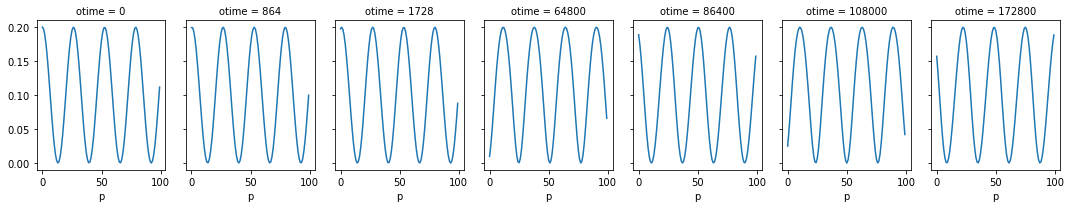

In [158]:
v_a.plot(col="otime", figsize=(15,3));

In [159]:
(v_a-_ds.profile__v)

<xarray.DataArray (otime: 7, p: 100, v: 100)>
array([[[ 0.        ,  0.00284701,  0.01122595, ...,  0.13526257,
          0.11208878,  0.08822664],
        [-0.00284701,  0.        ,  0.00837893, ...,  0.13241556,
          0.10924176,  0.08537963],
        [-0.01122595, -0.00837893,  0.        , ...,  0.12403663,
          0.10086283,  0.0770007 ],
        ...,
        [-0.13526257, -0.13241556, -0.12403663, ...,  0.        ,
         -0.0231738 , -0.04703593],
        [-0.11208878, -0.10924176, -0.10086283, ...,  0.0231738 ,
          0.        , -0.02386213],
        [-0.08822664, -0.08537963, -0.0770007 , ...,  0.04703593,
          0.02386213,  0.        ]],

       [[-0.00061243,  0.00223458,  0.01061351, ...,  0.13465014,
          0.11147635,  0.08761421],
        [-0.00082025,  0.00202676,  0.0104057 , ...,  0.13444232,
          0.11126853,  0.08740639],
        [-0.00664142, -0.00379441,  0.00458453, ...,  0.12862115,
          0.10544736,  0.08158522],
...
        [ 0.05443876,  0.03210969,  0.00739566, ...,  0.01225561,
          0.03540521,  0.05633223],
        [ 0.03057629,  0.00824722, -0.01646681, ..., -0.01160686,
          0.01154274,  0.03246976],
        [ 0.00808832, -0.01424075, -0.03895478, ..., -0.03409483,
         -0.01094523,  0.00998179]],

       [[ 0.00999408,  0.03391889,  0.05970736, ..., -0.01140503,
         -0.02568854, -0.03605167],
        [-0.01246483,  0.01145998,  0.03724845, ..., -0.03386394,
         -0.04814744, -0.05851058],
        [-0.03747995, -0.01355514,  0.01223333, ..., -0.05887906,
         -0.07316257, -0.0835257 ],
        ...,
        [ 0.01273585,  0.03666066,  0.06244913, ..., -0.00866325,
         -0.02294676, -0.03330989],
        [ 0.02890261,  0.05282742,  0.07861589, ...,  0.00750351,
         -0.00678   , -0.01714313],
        [ 0.04144263,  0.06536744,  0.09115591, ...,  0.02004353,
          0.00576002, -0.00460311]]])
Coordinates:
  * otime    (otime) int64 0 864 1728 64800 86400 108000 172800
Dimensions without coordinates: p, v

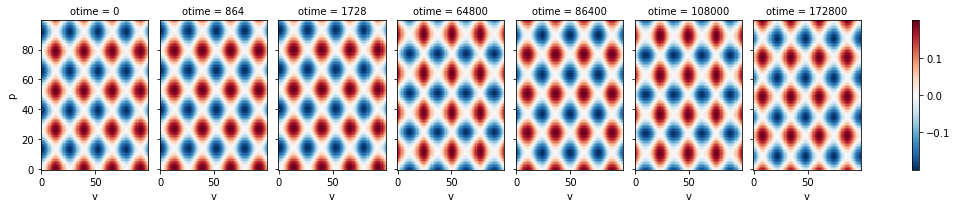

In [160]:
(v_a-_ds.profile__v).plot(col="otime", figsize=(15,3));

### Velocities plots

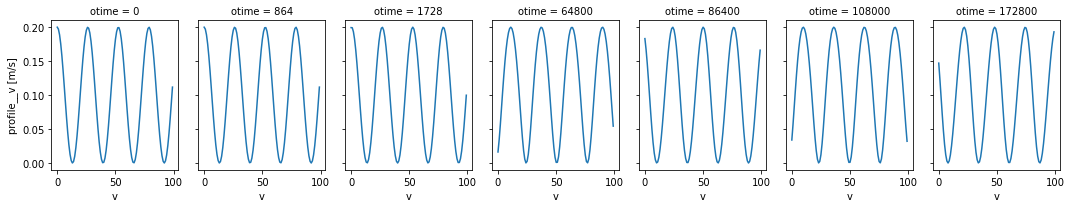

In [161]:
out_ds_advect2.profile__v.plot(col="otime", figsize=(15,3));

## Model for unadvected waves integrated with Euler
### Positions plots

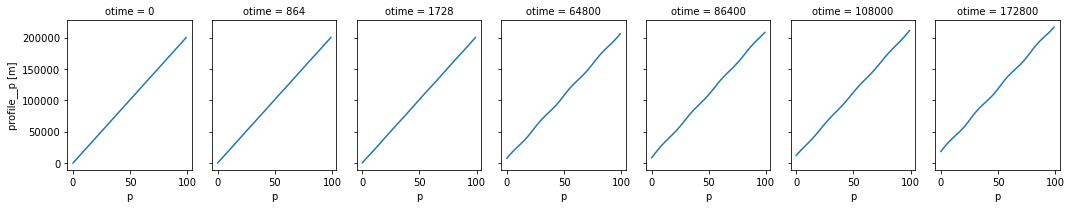

In [162]:
unadvect_model = advect_model.update_processes({"velocity": UnadvectedWave})
out_ds_unadvect = in_ds_advect.xsimlab.run(model=unadvect_model)
out_ds_unadvect.profile__p.plot(col="otime", figsize=(15,3));

### Velocities plots

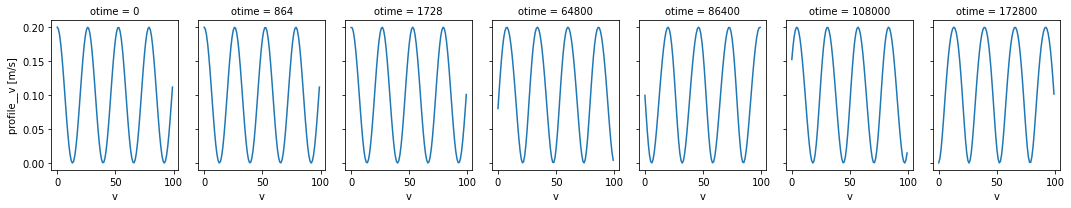

In [163]:
with unadvect_model:
    out_ds_unadvect2 = (in_ds_advect.xsimlab.update_vars(output_vars=out_vars).xsimlab.run())
out_ds_unadvect2.profile__v.plot(col="otime", figsize=(15,3));